In [1]:
import pandas as pd  # 导入csv文件的库
import numpy as np   # 进行矩阵运算的库
import matplotlib.pyplot as plt  # 导入强大的绘图库
import torch           # 一个深度学习的库PyTorch
import torch.nn as nn  # neural network, 神经网络
import torch.optim as optim  # 一个实现了各种优化算法的库
import warnings   
import seaborn as sns     # 避免一些可以忽略的报错
warnings.filterwarnings('ignore')  # 忽略警告信息

In [2]:
# 设置随机种子，保证实验结果可复现
import random

torch.backends.cudnn.deterministic = True   # 将 cuDNN 的随机数生成器设为确定性模式
torch.backends.cudnn.benchmark = False     # 关闭自动寻找最优卷积算法的功能
torch.manual_seed(42)                      # PyTorch 随机种子
np.random.seed(42)                       # NumPy 随机种子
random.seed(42)                          # Python 内置 random 种子

In [3]:
train_df=pd.read_excel('new-1.xlsx')
print(f"len(train_df):{len(train_df)}")
train_df.head()

len(train_df):1211


,TradingDate,Symbol,ShortName,ClosePrice,B
0,2018-01-05,1,平安银行,0.003774,0.962084
1,2018-01-08,1,平安银行,-0.025564,-0.786365
2,2018-01-09,1,平安银行,0.009259,1.877677
3,2018-01-10,1,平安银行,0.029817,1.038180
4,2018-01-11,1,平安银行,-0.005197,-0.386864


In [4]:
Close=train_df['ClosePrice'].values

In [5]:
from sklearn.preprocessing import MinMaxScaler
# 创建MinMaxScaler对象
scaler = MinMaxScaler()
# 将数据进行归一化
Close = scaler.fit_transform(Close.reshape(-1,1))

In [6]:
def split_data(data,time_step=12):
    dataX=[]
    datay=[]
    for i in range(len(data)-time_step):
        dataX.append(data[i:i+time_step])
        datay.append(data[i+time_step])
    dataX=np.array(dataX).reshape(len(dataX),time_step,-1)
    datay=np.array(datay)
    return dataX,datay

In [7]:
dataX,datay=split_data(Close,time_step=12)
print(f"dataX.shape:{dataX.shape},datay.shape:{datay.shape}")

dataX.shape:(1199, 12, 1),datay.shape:(1199, 1)


In [8]:
#划分训练集和测试集的函数
def train_test_split(dataX,datay,shuffle=True,percentage=0.8):
    """
    将训练数据X和标签y以numpy.array数组的形式传入
    划分的比例定为训练集:测试集=8:2
    """
    if shuffle:
        random_num=[index for index in range(len(dataX))]
        np.random.shuffle(random_num)
        dataX=dataX[random_num]
        datay=datay[random_num]
    split_num=int(len(dataX)*percentage)
    train_X=dataX[:split_num]
    train_y=datay[:split_num]
    test_X=dataX[split_num:]
    test_y=datay[split_num:]
    return train_X,train_y,test_X,test_y

In [9]:
train_X,train_y,test_X,test_y=train_test_split(dataX,datay,shuffle=False,percentage=0.8)
print(f"train_X.shape:{train_X.shape},test_X.shape:{test_X.shape}")
X_train,y_train=train_X,train_y

train_X.shape:(959, 12, 1),test_X.shape:(240, 12, 1)


In [10]:
# 定义CNN+LSTM模型类
class CNN_LSTM(nn.Module):
    def __init__(self, conv_input,input_size, hidden_size, num_layers, output_size):
        super(CNN_LSTM,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv=nn.Conv1d(conv_input,conv_input,1)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x=self.conv(x)
        h0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size) # 初始化隐藏状态h0
        c0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size)  # 初始化记忆状态c0
        #print(f"x.shape:{x.shape},h0.shape:{h0.shape},c0.shape:{c0.shape}")
        out, _ = self.lstm(x, (h0, c0))  # LSTM前向传播
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出作为预测结果
        return out

In [11]:
%%time 

test_X1=torch.Tensor(test_X)
test_y1=torch.Tensor(test_y)

# 定义输入、隐藏状态和输出维度
input_size = 1  # 输入特征维度
conv_input=12
hidden_size = 64  # LSTM隐藏状态维度
num_layers = 5  # LSTM层数
output_size = 1  # 输出维度（预测目标维度）

# 创建CNN_LSTM模型实例
model =CNN_LSTM(conv_input,input_size, hidden_size, num_layers, output_size)

#训练周期为500次
num_epochs=500
batch_size=64#一次训练的数量
#优化器
optimizer=optim.Adam(model.parameters(),lr=0.0001,betas=(0.5,0.999))
#损失函数
criterion=nn.MSELoss()

train_losses=[]
test_losses=[]

print(f"start")

for epoch in range(num_epochs):
    
    random_num=[i for i in range(len(train_X))]
    np.random.shuffle(random_num)
    
    train_X=train_X[random_num]
    train_y=train_y[random_num]
    
    train_X1=torch.Tensor(train_X[:batch_size])
    train_y1=torch.Tensor(train_y[:batch_size])
    
    #训练
    model.train()
    #将梯度清空
    optimizer.zero_grad()
    #将数据放进去训练
    output=model(train_X1)
    #计算每次的损失函数
    train_loss=criterion(output,train_y1)
    #反向传播
    train_loss.backward()
    #优化器进行优化(梯度下降,降低误差)
    optimizer.step()
    
    if epoch%50==0:
        model.eval()
        with torch.no_grad():
            output=model(test_X1)
            test_loss=criterion(output,test_y1)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"epoch:{epoch},train_loss:{train_loss},test_loss:{test_loss}")

start
epoch:0,train_loss:0.26079609990119934,test_loss:0.2439764440059662
epoch:50,train_loss:0.07430975884199142,test_loss:0.05934285372495651
epoch:100,train_loss:0.009747053496539593,test_loss:0.010985697619616985
epoch:150,train_loss:0.010866553522646427,test_loss:0.010901791043579578
epoch:200,train_loss:0.009516796097159386,test_loss:0.010945009998977184
epoch:250,train_loss:0.015864554792642593,test_loss:0.011005599051713943
epoch:300,train_loss:0.017052307724952698,test_loss:0.011037405580282211
epoch:350,train_loss:0.014035278931260109,test_loss:0.011005022563040257
epoch:400,train_loss:0.013681799173355103,test_loss:0.011029175482690334
epoch:450,train_loss:0.015060166828334332,test_loss:0.011291042901575565
CPU times: total: 1min 19s
Wall time: 22.1 s


In [12]:
def mse(pred_y,true_y):
    return np.mean((pred_y-true_y) ** 2)

In [13]:
train_X1=torch.Tensor(X_train)
train_pred=model(train_X1).detach().numpy()
test_pred=model(test_X1).detach().numpy()
pred_y=np.concatenate((train_pred,test_pred))
pred_y=scaler.inverse_transform(pred_y).T[0]
true_y=np.concatenate((y_train,test_y))
true_y=scaler.inverse_transform(true_y).T[0]
print(f"mse(pred_y,true_y):{mse(pred_y,true_y)}")

mse(pred_y,true_y):0.00048014710607280955


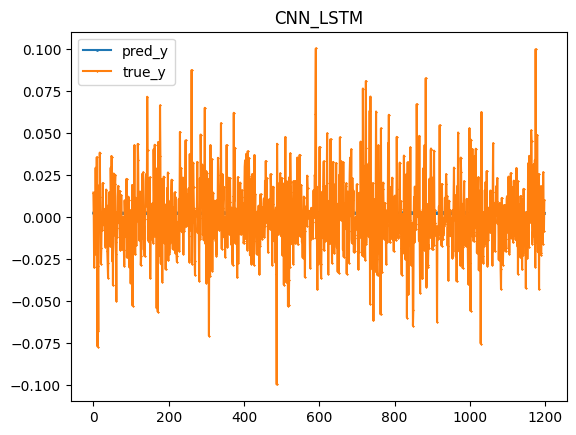

In [16]:
plt.title("CNN_LSTM")
x=[i for i in range(len(true_y))]
plt.plot(x,pred_y,marker="o",markersize=1,label="pred_y")
plt.plot(x,true_y,marker="x",markersize=1,label="true_y")
plt.legend()
plt.show()